In [2]:
#Gershman 2012 paper result recreation

In [3]:
#section 1: Gibb's sampling verification
#sampling a 2D Gaussian as an example
#covariance matrix: [[2,1],[1,2]]
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from gershman_12_functions import p_w,p_pi_l,p_pi_r,proposal_function,binary_proposal,sample_rejection_w
from gershman_12_functions import sample_rejection_pi_l,sample_rejection_pi_r
from ring_12_functions import p_w_ring, p_pi_l_ring, p_pi_r_ring, proposal_function_ring, binary_proposal_ring
from ring_12_functions import sample_rejection_w_ring, sample_rejection_pi_l_ring, sample_rejection_pi_r_ring, corr

x = np.arange(-3,3,0.01)
y = np.arange(-3,3,0.01)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.5*2/3*(X**2-X*Y+Y**2))

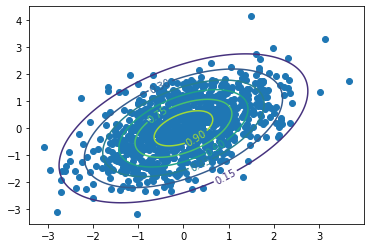

In [4]:
#Gibb's sampler in 2D
#sample from conditional distribution
#x|y=a ~ N(0.5a,3/4)
#y|x=b ~ N(0.5b,3/4)
x_samples = [np.random.normal()]
y_samples = [np.random.normal()]
for i in range(1000):
    x_samples.append(np.random.normal()*(3/4)**0.5+0.5*y_samples[-1])
    y_samples.append(np.random.normal()*(3/4)**0.5+0.5*x_samples[-1])
    
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
plt.scatter(np.array(x_samples),np.array(y_samples))
ax.clabel(CS, inline=True, fontsize=10)
plt.show()

In [5]:
#data structure:
#pi_l, pi_r: outlier array, 5*5
#w: weight array, 5*5
#s: percept array, 5*5
#x_l, x_r: visual input at right and left eyes
#image model: s_n = w_n*x_l_n + (1-w_n)*x_r_n (s=w*x_l+(1-w)*x_r)

In [6]:
#define constants
var = 0.005
beta = 10
gamma = 10
alpha = 0
tau = 1/250
b = np.zeros((32,32))

In [7]:
index = (1,1)
x_l = -np.ones((4,4))
x_r = np.ones((4,4))
pi_l = np.zeros((4,4))
pi_r = np.zeros((4,4))
pi_r[1,1] = 1
w = np.zeros((4,4))
print(p_pi_r(index,w,x_l,x_r,pi_l,pi_r,beta,var,b,tau,gamma,alpha))

pi_r[1,1] = 0
print(p_pi_r(index,w,x_l,x_r,pi_l,pi_r,beta,var,b,tau,gamma,alpha))

0.8521437889662113
1.0


In [8]:
sample_list = []
while len(sample_list)<1000000:
    pi_r_star = binary_proposal(pi_r, index, 0.5)
    acc = sample_rejection_pi_r(index,w,x_l,x_r,pi_l,pi_r,pi_r_star,beta,var,b,tau,gamma,alpha)
    if acc:
        pi_r = pi_r_star
        sample_list.append(pi_r[index[1],index[1]])
    else:
        sample_list.append(pi_r[index[1],index[1]])
print(sum(sample_list)/1000000)

0.460177


In [67]:
#p_w and sampling on w verified
#p_pi and binary sampling on p_pi verified

In [76]:
def simulation(var,beta,gamma,alpha,tau,b):
    dim=5
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((5,5))
    x_r = np.zeros((5,5))
    w = random.rand(5,5)
    pi_l = random.randint(0,2,(5,5))
    pi_r = random.randint(0,2,(5,5))

    s = []
    for m in range(int(2e6)):
        if m/100000 ==0:
            print(m)
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal(pi_r, index, 1)
                acc = sample_rejection_pi_r(index,w,x_l,x_r,pi_l,pi_r,pi_r_star,beta,var,b,tau,gamma,alpha)
                if acc:
                    pi_r = pi_r_star

        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal(pi_l, index, 1)
                acc = sample_rejection_pi_l(index,w,x_l,x_r,pi_l,pi_l_star,pi_r,beta,var,b,tau,gamma,alpha)
                if acc:
                    pi_l = pi_l_star
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function(w, index)
                    acc = sample_rejection_w(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,gamma,alpha)
                    if acc:
                        w = w_star
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
    return s

In [ ]:
state_var0005 = simulation(0.005,10,10,0,1/250,np.zeros((32,32)))
print('done')
state_var0025 = simulation(0.025,10,10,0,1/250,np.zeros((32,32)))
print('done')
state_var0050 = simulation(0.050,10,10,0,1/250,np.zeros((32,32)))
print('done')
state_var0100 = simulation(0.100,10,10,0,1/250,np.zeros((32,32)))
print('done')

0
done
0


Text(0, 0.5, 'no.nodes>0')

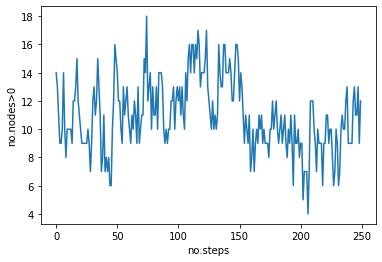

In [22]:
plt.plot(s[-3000:-2750])
plt.xlabel('no.steps')
plt.ylabel('no.nodes>0')

In [11]:
def domi_period_count(state_list_input,dim = 5):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>0.2*dim**2 and state_list_input[i]<0.2*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<0.8*dim**2 and state_list_input[i]>0.8*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return np.array(domi_list)

In [72]:
domi_period = np.sort(domi_period_count(s,dim = 5))
print(np.mean(domi_period))
domi_period = domi_period[:-200]
print(len(domi_period))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

512.597601598934


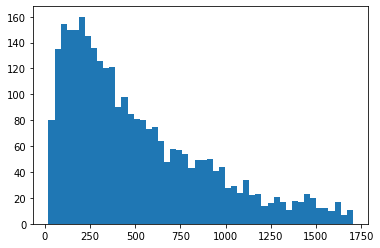

In [71]:
plt.hist(domi_period,50)

[  1.46179757   2.9324049  400.60016713]


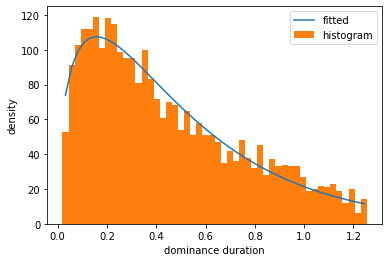

In [20]:
from scipy.optimize import curve_fit
y,bins=np.histogram(domi_period[:-200],50)
x = []
for i in range(1,51):
    x.append((bins[i]+bins[i-1])/2)
x=np.array(x)

def gamma(x,a,b,c):
    return c*np.exp(-b*x)*x**(a-1)

popt,pcov = curve_fit(gamma,x/1000,y)

plt.plot(x/1000,gamma(x/1000,popt[0],popt[1],popt[2]))
plt.hist(domi_period[:-200]/1000,50)

plt.xlabel('dominance duration')
plt.ylabel('density')
plt.legend(['fitted','histogram'])

print(popt)

In [170]:
#travelling wave, ring RMF
#ring RMF is represented as an array (last elemnt 'connected' to the first)

In [172]:
#define new functions

In [41]:
#main implementation code: ring RMF
dim = 20
sampling_order = np.arange(dim)

#set initial condition for w, pi_r, pi_l
#set visual input x_r, x_l as conflicting input
x_l = np.ones(dim)
x_r = np.zeros(dim)
w = random.rand(dim)
pi_l = random.randint(0,2,(dim))
pi_r = random.randint(0,2,(dim))
b = np.zeros(dim)

#define constants
var = 0.005
beta = 80
gamma = 80
alpha = 0
tau = 1/250

#w_list = []
#pi_l_list = []
#pi_r_list = []
s = []
state = []
for m in range(int(1e6)):
    #order of sweep is randomnized
    random.shuffle(sampling_order)
    #the following for loop update on pi_l
    for i in sampling_order:
        pi_r_star = binary_proposal_ring(pi_r, i, 1)
        acc = sample_rejection_pi_r_ring(i,w,x_l,x_r,pi_l,pi_r,pi_r_star,beta,var,b,tau,gamma,alpha)
        if acc:
            pi_r = pi_r_star

    #the following for loop update on pi_r
    for i in sampling_order:

        pi_l_star = binary_proposal_ring(pi_l, i, 1)
        acc = sample_rejection_pi_l_ring(i,w,x_l,x_r,pi_l,pi_l_star,pi_r,beta,var,b,tau,gamma,alpha)
        if acc:
            pi_l = pi_l_star
    
    #the following for loop update on w
    for i in sampling_order:
        w_star = proposal_function_ring(w, i)
        acc = sample_rejection_w_ring(i,w,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,gamma,alpha)
        if acc:
            w = w_star
    #w_list.append(w)
    s_i = w*x_l+(1-w)*x_r
    s.append(s_i)
    state.append(len(np.where(s_i>0.5)[0]))

In [42]:
neuron_response = []
for i in range(dim):
    neuron_response.append([s_i[i] for s_i in s])

In [43]:
corr_list = []
for j in range(1,dim):
    corr_list.append(corr(neuron_response[0],neuron_response[j],300))

Text(0.5, 1.0, 'travelling wave by correlation')

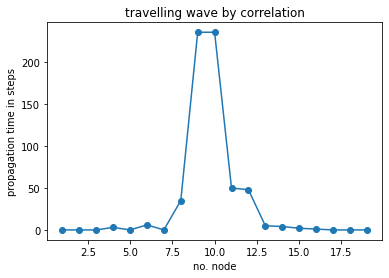

In [54]:
pro_t = [np.argmax(corr) for corr in corr_list]
plt.scatter(np.arange(1,20),pro_t)
plt.plot(np.arange(1,20),pro_t)
plt.xlabel('no. node')
plt.ylabel('propagation time in steps')
plt.title('travelling wave by correlation')

In [70]:
print(np.where(corr_list[0]==np.max(corr_list[0])))
print(np.where(corr_list[1]==np.max(corr_list[1])))
print(np.where(corr_list[2]==np.max(corr_list[2])))
print(np.where(corr_list[3]==np.max(corr_list[3])))
print(np.where(corr_list[4]==np.max(corr_list[4])))

(array([0]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([6]),)


In [287]:
state = [len(np.where(s_i>0.5)[0]) for s_i in s]

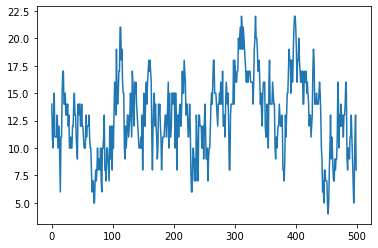

In [292]:
plt.plot(state[2000:2500])

In [55]:
def domi_period_count(state_list_input,dim = 4):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>0.3*dim**2 and state_list_input[i]<0.3*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<0.7*dim**2 and state_list_input[i]>0.7*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return np.array(domi_list)

(array([19., 29., 21., 18.,  5., 12.,  9.,  6.,  6.,  3.,  5.,  2., 10.,
         1.,  6.,  3.,  5.,  2.,  4.,  2.,  4.,  1.,  0.,  2.,  2.,  1.,
         2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([  5. ,  11.5,  18. ,  24.5,  31. ,  37.5,  44. ,  50.5,  57. ,
         63.5,  70. ,  76.5,  83. ,  89.5,  96. , 102.5, 109. , 115.5,
        122. , 128.5, 135. , 141.5, 148. , 154.5, 161. , 167.5, 174. ,
        180.5, 187. , 193.5, 200. , 206.5, 213. , 219.5, 226. , 232.5,
        239. , 245.5, 252. , 258.5, 265. ]),
 <BarContainer object of 40 artists>)

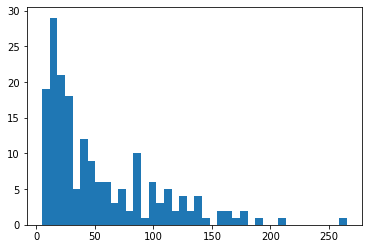

In [57]:
plt.hist(np.array(domi_period_count(state)),40)

In [56]:
#main implementation code
var1 = 0.01
beta = 10
gamma = 10
alpha = 0
tau = 1/250
b = np.zeros((32,32))

dim = 5
sampling_order_i = np.arange(dim)
sampling_order_j = np.arange(dim)

#set initial condition for w, pi_r, pi_l
#set visual input x_r, x_l as conflicting input
x_l = np.ones((5,5))
x_r = np.zeros((5,5))
w = random.rand(5,5)
pi_l = random.randint(0,2,(5,5))
pi_r = random.randint(0,2,(5,5))


w_list1 = []
#pi_l_list = []
#pi_r_list = []
s1 = []

for m in range(int(2e6)):
    #order of sweep is randomnized
    random.shuffle(sampling_order_i)
    random.shuffle(sampling_order_j)
    #the following for loop update on pi_l
    for i in sampling_order_i:
        for j in sampling_order_j:
            index = (i,j)
            pi_r_star = binary_proposal(pi_r, index, 1)
            acc = sample_rejection_pi_r(index,w,x_l,x_r,pi_l,pi_r,pi_r_star,beta,var1,b,tau,gamma,alpha)
            if acc:
                pi_r = pi_r_star

    #the following for loop update on pi_r
    for i in sampling_order_i:
        for j in sampling_order_j:
            index = (i,j)
            pi_l_star = binary_proposal(pi_l, index, 1)
            acc = sample_rejection_pi_l(index,w,x_l,x_r,pi_l,pi_l_star,pi_r,beta,var1,b,tau,gamma,alpha)
            if acc:
                pi_l = pi_l_star
    
    #the following for loop update on w
    for i in sampling_order_i:
        for j in sampling_order_j:
            index = (i,j)
            w_star = proposal_function(w, index)
            acc = sample_rejection_w(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var1,b,tau,gamma,alpha)
            if acc:
                w = w_star
    
    #w_list.append(w)
    s_i = w*x_l+(1-w)*x_r
    s1.append(s_i)

In [73]:
state_list2 = [len(np.where(si>0.5)[0]) for si in s1]


domi_period2 = np.sort(domi_period_count(state_list2,dim = 5))
domi_period2 = domi_period2[:-200]
print(len(domi_period))
print(np.mean(domi_period2))

3002
509.58196721311475


[  1.41510215   2.8123335  362.1005919 ]


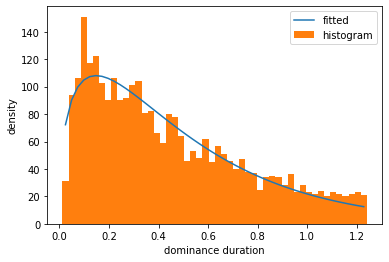

In [65]:
from scipy.optimize import curve_fit
y,bins=np.histogram(domi_period2[:-200],50)
x = []
for i in range(1,51):
    x.append((bins[i]+bins[i-1])/2)
x=np.array(x)

def gamma(x,a,b,c):
    return c*np.exp(-b*x)*x**(a-1)

popt,pcov = curve_fit(gamma,x/1000,y)

plt.plot(x/1000,gamma(x/1000,popt[0],popt[1],popt[2]))
plt.hist(domi_period2[:-200]/1000,50)

plt.xlabel('dominance duration')
plt.ylabel('density')
plt.legend(['fitted','histogram'])

print(popt)

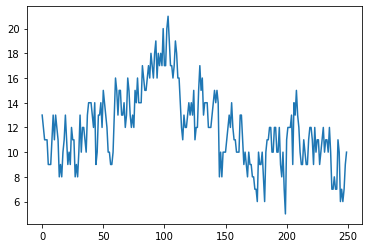

In [69]:
plt.plot(state_list2[-2000:-1750])